# Explore here

In [ ]:
import pandas as pd
import numpy as np, random
import sklearn as skt



In [ ]:
df_rd_col = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv")
df_rd_col.head(4)
df_rd_col.describe()


In [ ]:
df_rd_col.info()

1) Tenemos la funcion KMeans, vamos a separar por clusters parametrizando correctamente.
KMeans
class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

In [ ]:
df_rd_col = df_rd_col.drop_duplicates().reset_index(drop = True)
df_rd_col = df_rd_col.fillna(0)

Solo nos piden clusterizar 3 variables, que ademas tienen un rango similar y con rangos cercanos, optare por un MinMax antes de utilizar KMEANS. Usaria una NormScalSTD si fuera todo el dataframe, ya que ahí,
si existen rangos muy diferentes y diferencias entre el 3Q y valor max dispares.

In [ ]:
#PRIMERAMENTE realizamos un drop de columnas

df_rd_3var = df_rd_col.drop(axis=1,columns=['HouseAge','AveRooms','Population','AveBedrms','AveOccup','MedHouseVal'])
df_rd_3var.head(1)

In [32]:
#Normalizacion MinMax:
from sklearn.preprocessing import MinMaxScaler
mmx = MinMaxScaler()
df_3_mmx = df_rd_3var.copy()
df_3_mmx = mmx.fit(df_rd_3var)
df_3_mmx = mmx.transform(df_rd_3var)
df_3_mmx
df3mmx = pd.DataFrame(df_3_mmx)
df3mmx.to_csv("/workspaces/K-medias/data/processed/df3mmxtrain.csv", index=False)
#REALIZO FUNCION SPLIT TRAIN/TEST, AL NO HABER VARIABLE TARGET, OMITO EL y TRAIN/TEST.
from sklearn.model_selection import train_test_split
import os
X_train, X_test,  = train_test_split(df3mmx, test_size=1/3, random_state=33)
X_train.to_csv("/workspaces/K-medias/data/processed/df3mmx_X_Tr", index=False)
X_test.to_csv("/workspaces/K-medias/data/processed/df3mmx_X_Tt", index=False)


AHORA QUE TENEMOS NUESTROS DATOS ARREGLADOS, y la funcion split preparada, solo con datos en X, ya que no hay target. PROCEDO A IMPLEMENTAR EL K-MEAN.

In [41]:
from sklearn.cluster import KMeans
for i in range (1, 6):
    kmn3 = KMeans(n_clusters=6,max_iter=216,n_init='auto',random_state=33)
    kmn3.fit(X_train, X_test)
#A partir de nuestro df pasado por el modelo KMeans, creamos el Y train, que a su vez son los cluster, ya que 
#las target son todas las variables que estan en las columnas del X_train,test, neesitamos el componente y para
#que las predicciones funcionen, al mismo tiempo sera una nueva columna en los dos dataframe de X.
y_train = list(kmn3.labels_)
X_train["cluster"] = y_train
X_train.head()

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

ValueError: Could not interpret value `Latitude` for `x`. An entry with this name does not appear in `data`.

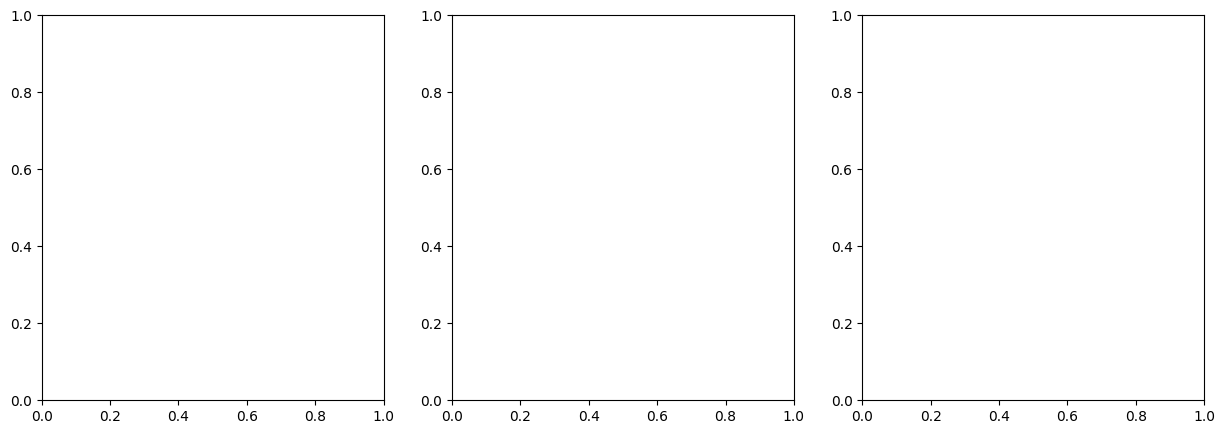

In [40]:
#Evaluamos los resultados. a traves de la interpretacion de los cluster en los graficos.
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(1, 3, figsize = (15, 5))

sns.scatterplot(ax = axis[0], data = X_train, x = "Latitude", y = "Longitude", hue = "cluster", palette = "deep")
sns.scatterplot(ax = axis[1], data = X_train, x = "Latitude", y = "MedInc", hue = "cluster", palette = "deep")
sns.scatterplot(ax = axis[2], data = X_train, x = "Longitude", y = "MedInc", hue = "cluster", palette = "deep")
plt.tight_layout()

plt.show()